In [155]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import warnings
from sklearn import svm
from sklearn.model_selection import train_test_split 


In [148]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Functions

In [140]:
def change_add_var(df):
    # Change the colum HasPitLap, to check if in the next lap it made the lap, and change name to PitNextLap
    
    #Is changing in the current lap, needs to change in the next
    df["NumberPitStops"] = df.groupby(["Year", "RaceNumber", "Driver"])["NumberPitStops"].shift(1).fillna(0)

    #Data from previus lap
    df["TimeLap"] = df.groupby(["Year", "RaceNumber", "Driver"])["TimeLap"].shift(1).fillna(0)

    return df

In [141]:
def remonve_var(df):
    df = df.drop(['DriverNumber'], axis=1)
    df = df.drop(['DriverAhead'], axis=1)
    df = df.drop(['DriverBehind'], axis=1)
    df = df.drop(['TimePit'], axis=1)
    return df

In [142]:
def remove_rain(df):
    initial_races = 0
    rain_races= 0 
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            initial_races+=1
            val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]
            #If in that race any driver uses Intermediate or wet tyres, delete the all the sace
            if ('INTERMEDIATE' in val['Compound'].values or 'WET' in val['Compound'].values):
                rain_races +=1
                df = df.drop(val.index)

    print("Total races in the DataSet: " + str(initial_races))
    print("Number of races that have been eliminated due to rain: " + str(rain_races))

    return (df)

In [143]:
def remove_retired(df):
    list_remove = pd.DataFrame()
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
                val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
                if ('Finished' != val["ResultStatus"].iloc[0] and '+1 Lap' != val["ResultStatus"].iloc[0] and '+2 Laps' != val["ResultStatus"].iloc[0]):
                    list_remove = list_remove.append({'year': year, 'driver': driver, 'problem': val["ResultStatus"].iloc[0]}, ignore_index=True)
                    df = df.drop(val.index) 
                elif val["NumberPitStops"].iloc[-1] >4:  
                    list_remove = list_remove.append({'year': year, 'driver': driver, 'problem': "+4 pit stops"}, ignore_index=True)
                    df = df.drop(val.index)
    
    return df, list_remove

In [144]:
def remove_null (df): 
    #Qualy Position and GridPosition
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
                val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
                if ( np.isnan(val["QualyPosition"].iloc[0])):
                    df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "QualyPosition"] = val["Position"].iloc[0]
                if ( val["GridPosition"].iloc[0] == 0):
                    df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "GridPosition"] = val["Position"].iloc[0]
    
    #DriverStandings
    df['DriverStandings'] = df['DriverStandings'].fillna(0)

    return df

### Preprocessing


In [145]:
v_categorical= [ 'RaceName', 'Driver', 'Team', 'Compound', 'TrackStatus'] 
v_numerical = ['RaceNumber', 'GridPosition', 'LapNumber', 'TyreLife', 
               'QualyPosition', 'DriverStandings', 'Position',
               'NumberPitStops']
v_binary = ['TyresChange','DriverAheadPit', 'DriverBehindPit' ]
v_date= ['TimeLap', 'TimeDiffAhead', 'TimeDiffBehind', 'TimeDiffToLeader']

In [149]:
def categorical_enc (df):
    v_cat= ['RaceName', 'Driver', 'Team', 'Compound'] 

    #Track status
    trackStatus_encoded =  pd.DataFrame()
    df['TrackStatus'] = df['TrackStatus'].astype(str)
    for num in range(1, 8):
        col_name = 'status_' + str(num)
        trackStatus_encoded[col_name] = df['TrackStatus'].str.contains(str(num)).astype(int)
    
    #the rest
    ohe = OneHotEncoder(sparse=False)
    categorical_encoded = pd.DataFrame(ohe.fit_transform(df[v_cat]))
    # Get feature names from encoder and combine with unique values
    feature_names = [f"{col}_{val}" for col, vals in zip(v_cat, v_cat) for val in ohe.categories_[v_cat.index(col)]]
    categorical_encoded.columns = feature_names

    #Combine with track status 
    categorical_encoded = pd.concat([categorical_encoded, trackStatus_encoded], axis=1)
   
    return categorical_encoded

In [150]:
def binary_enc (df):
    #It's already encoded, juto convert all to int 
    binary_encoded = df[v_binary].astype(int)
    return binary_encoded

In [151]:
def numerical_enc (df):
    #StandarScaler
    scaler = StandardScaler()
    numerical_encoded = df.groupby(['Year', 'RaceNumber'])[v_numerical].apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index))

    return numerical_encoded

In [152]:
def date_enc(df):
    #Convert the times to secods 
    df['TimeLap'] = pd.to_timedelta(df['TimeLap']).dt.total_seconds()
    df['TimeDiffAhead'] = pd.to_timedelta(df['TimeDiffAhead']).dt.total_seconds()
    df['TimeDiffBehind'] = pd.to_timedelta(df['TimeDiffBehind']).dt.total_seconds()
    df['TimeDiffToLeader'] = pd.to_timedelta(df['TimeDiffToLeader']).dt.total_seconds()

    scaler = StandardScaler()
    date_encoded = df.groupby(['Year', 'RaceNumber'])[v_date].apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index))

    return date_encoded

In [153]:
def encode_df (df): 
    categorical_encoded = categorical_enc(df)
    binary_encoded = binary_enc(df)
    numerical_encoded = numerical_enc(df)
    date_encoded = date_enc(df)

    df_encoded = pd.concat([categorical_encoded, binary_encoded, numerical_encoded, date_encoded], axis=1)
    return df_encoded

## Prepare data

### Apply functions

In [154]:
df_2023 = pd.read_csv("data/2023.csv", sep = '\t') 
df_2023 = change_add_var(df_2023)
df_2023 = remonve_var(df_2023)
df_2023 = remove_rain(df_2023)
df_2023, list_remove = remove_retired(df_2023)
df_2023 = remove_null (df_2023)
df_2023 = df_2023.reset_index(drop=True)  
df_encoded_2023 = encode_df (df_2023)
df_encoded_2023

Total races in the DataSet: 9
Number of races that have been eliminated due to rain: 1


,RaceName_Australian Grand Prix,RaceName_Austrian Grand Prix,RaceName_Azerbaijan Grand Prix,RaceName_Bahrain Grand Prix,RaceName_Canadian Grand Prix,RaceName_Miami Grand Prix,RaceName_Saudi Arabian Grand Prix,RaceName_Spanish Grand Prix,Driver_ALB,Driver_ALO,...,LapNumber,TyreLife,QualyPosition,DriverStandings,Position,NumberPitStops,TimeLap,TimeDiffAhead,TimeDiffBehind,TimeDiffToLeader
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.701537,-1.018667,-1.626310,0.000000,-1.641654,-1.443321,-6.863362,-0.867385,-0.608320,-1.550455
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.640431,-0.853738,-1.626310,0.000000,-1.641654,-1.443321,0.038231,-0.867385,-0.510378,-1.550455
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.579325,-0.688809,-1.626310,0.000000,-1.641654,-1.443321,-0.034605,-0.867385,-0.428086,-1.550455
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.518219,-0.523880,-1.626310,0.000000,-1.641654,-1.443321,-0.032375,-0.867385,-0.320931,-1.550455
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.457113,-0.358952,-1.626310,0.000000,-1.641654,-1.443321,-0.034466,-0.867385,-0.241542,-1.550455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.482617,2.453472,1.427514,1.302978,1.430797,-0.182891,0.017614,-0.801128,-0.878062,2.584907
8403,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.531696,2.576512,1.427514,1.302978,1.430797,-0.182891,0.064193,-0.667732,-0.885501,2.663086
8404,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.580774,2.699553,1.427514,1.302978,1.611177,-0.182891,-0.064759,-0.629154,-0.961287,2.761947
8405,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.629853,2.822594,1.427514,1.302978,1.611177,-0.182891,0.018253,-0.129035,-0.961287,2.779971


### Get data

In [156]:
df_encoded = pd.read_csv("data/encoded_data.csv", sep="\t")
df = pd.read_csv("data/combined_dataframe_clean.csv", sep="\t")

In [157]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded, df['HasPitLap'], test_size=0.1, random_state=4815)

## Apply algorithim

In [158]:
y_train_full = df['HasPitLap']
X_train_full = df_encoded.loc[y_train_full.index]


In [159]:
SVM_res = svm.SVC(class_weight="balanced")

SVM_res.fit(X_train, y_train)

SVC(class_weight='balanced')

In [132]:
def plot(name, plot_df):
    # Define color palette and labels
    palette = {0: 'white', 1: "#0072B2", 2: "#E07C24", 3: "#009E73"}
    labels = { 1: 'Predicted but didn\'t pit', 2: 'Pit but not predicted', 3: 'Pit and predicted'}
    label_colors = { 1:  "#0072B2", 2: "#E07C24", 3: "#009E73"}

    # Create scatter plot
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=plot_df, x='Lap', y='Driver', hue='ColorCode', palette=palette, s=100)

    plt.legend(title='Legend', labels=labels.values(),  loc='upper right', 
            handles=[plt.Line2D([], [], marker='o', color=label_colors[i], linestyle='') for i in labels.keys()])
    
    plt.savefig("img/2023/race_"+str(name), dpi=300 , bbox_inches='tight')
    plt.show()

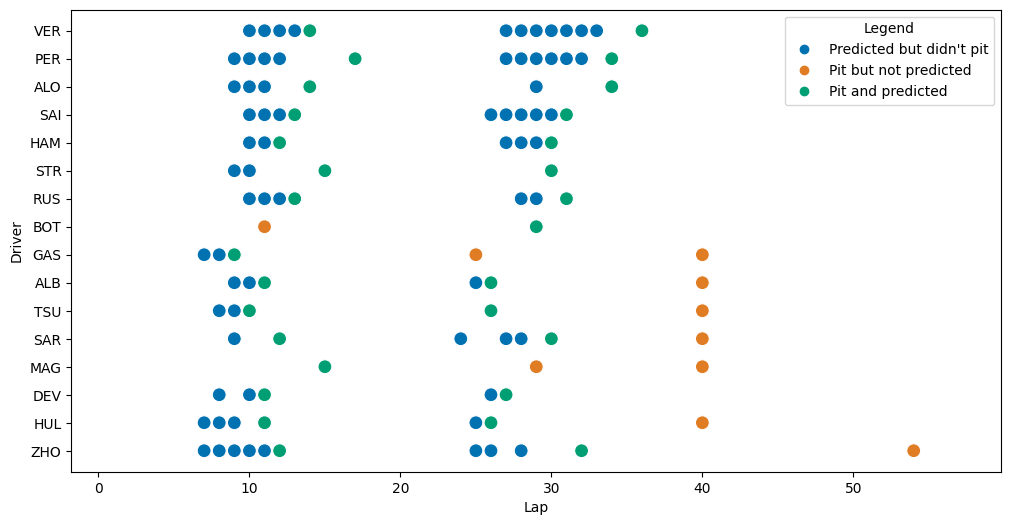

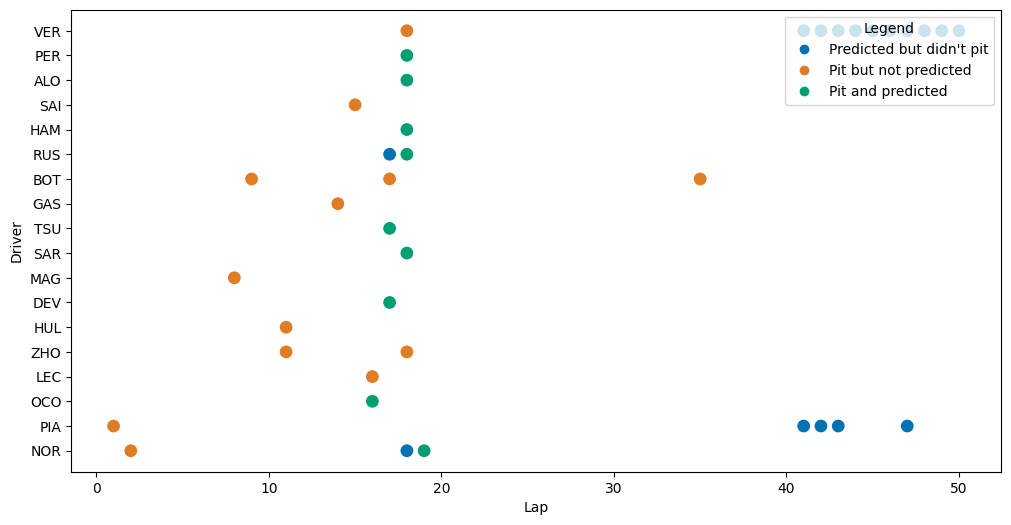

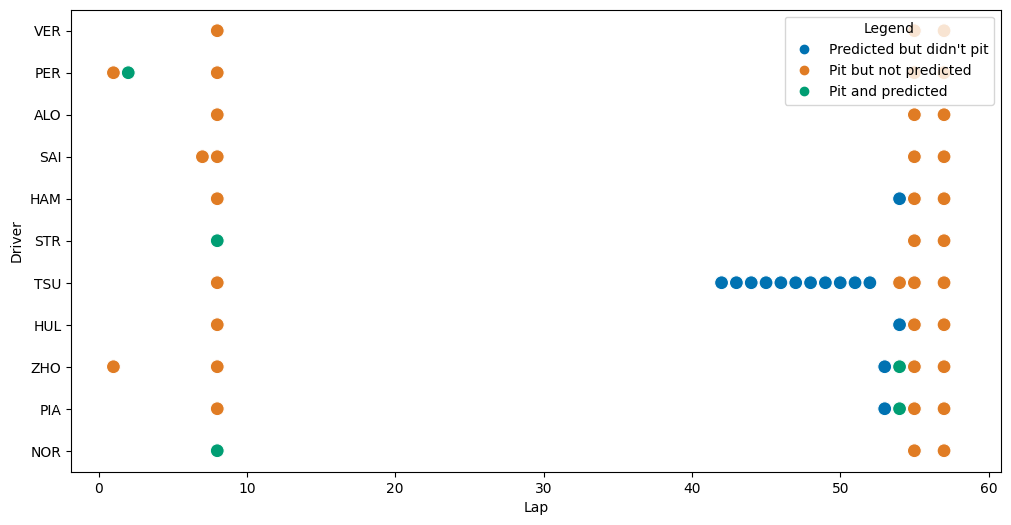

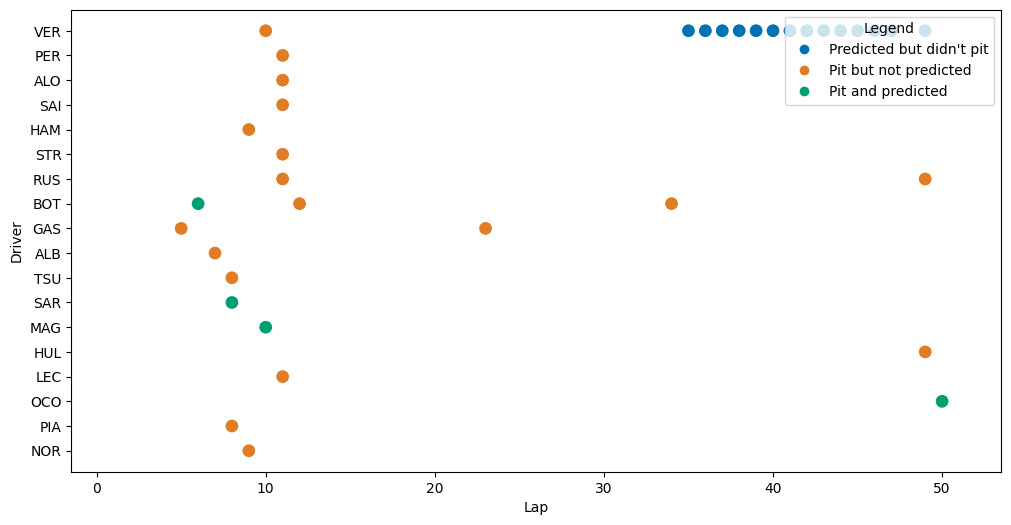

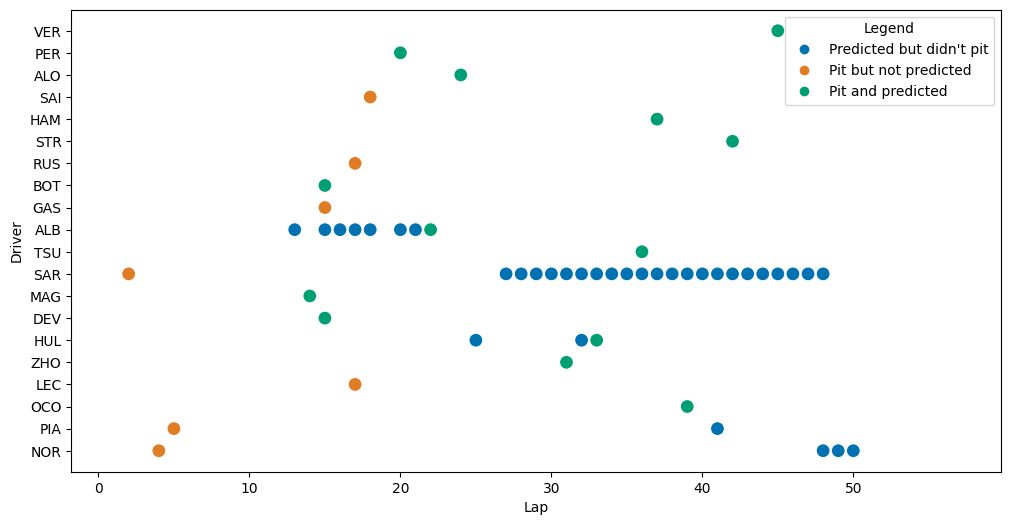

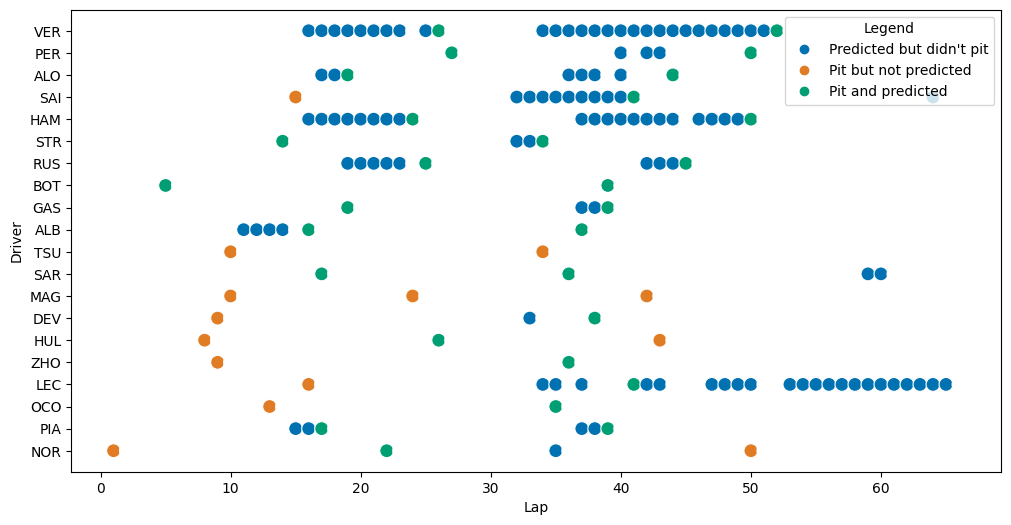

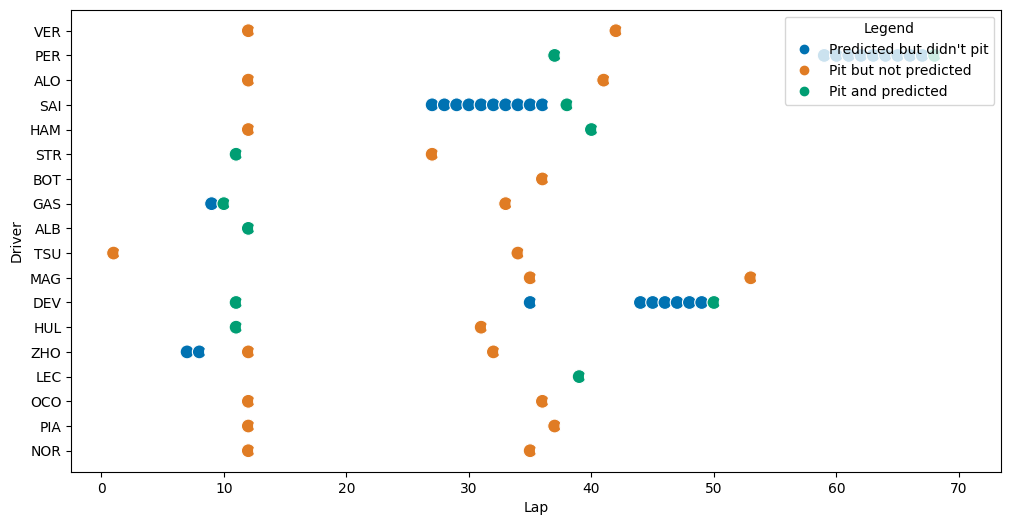

In [133]:
for receN in range(1,df_2023['RaceNumber'].unique().max()):
    df_list = []
    for driver in df_2023['Driver'].unique() :

        race_driver = df_2023[(df_2023['Driver'] == driver)  & (df_2023['RaceNumber'] == receN)]
        if(len(race_driver) == 0) : #its one of the deleted drivers
            continue
        
        to_predict = df_encoded_2023.loc[race_driver.index].reindex(columns=X_train_full.columns, fill_value=0)
        
        null_cols = to_predict.columns[to_predict.isnull().any()]

        predictions = SVM_res.predict(to_predict).astype(int)
        real = race_driver['HasPitLap'].values
        #real = race_driver['PitNextLap'].values


        laps = np.arange(1, len(real)+1)

        driver_df = pd.DataFrame({'Driver': [driver]*len(real),
                                'Real': real,
                                'Predict': predictions,
                                'Lap': laps})

        df_list.append(driver_df)

    if (len(df_list)==0):
        continue
    
    plot_df = pd.concat(df_list, ignore_index=True)

    # Create a colum for the color 
    # 0: No pit, not predicted 
    # 1: No pit, yes predicted 
    # 2: Yes pit, not predicted 
    # 3: Yes pit, yes predicted 
    plot_df['ColorCode'] = (plot_df['Real'] * 2 + plot_df['Predict']).astype(int)
    plot(receN, plot_df)

In [162]:
SVM_res = svm.SVC(class_weight="balanced",C= 0.1, gamma=1 , kernel= 'poly')
SVM_res.fit(X_train, y_train)

SVC(C=0.1, class_weight='balanced', gamma=1, kernel='poly')

In [135]:
def plot(name, plot_df):
    # Define color palette and labels
    palette = {0: 'white', 1: "#0072B2", 2: "#E07C24", 3: "#009E73"}
    labels = { 1: 'Predicted but didn\'t pit', 2: 'Pit but not predicted', 3: 'Pit and predicted'}
    label_colors = { 1:  "#0072B2", 2: "#E07C24", 3: "#009E73"}

    # Create scatter plot
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=plot_df, x='Lap', y='Driver', hue='ColorCode', palette=palette, s=100)

    plt.legend(title='Legend', labels=labels.values(),  loc='upper right', 
            handles=[plt.Line2D([], [], marker='o', color=label_colors[i], linestyle='') for i in labels.keys()])
    
    plt.savefig("img/2023/correct/race_"++str(name), dpi=300 , bbox_inches='tight')
    plt.show()

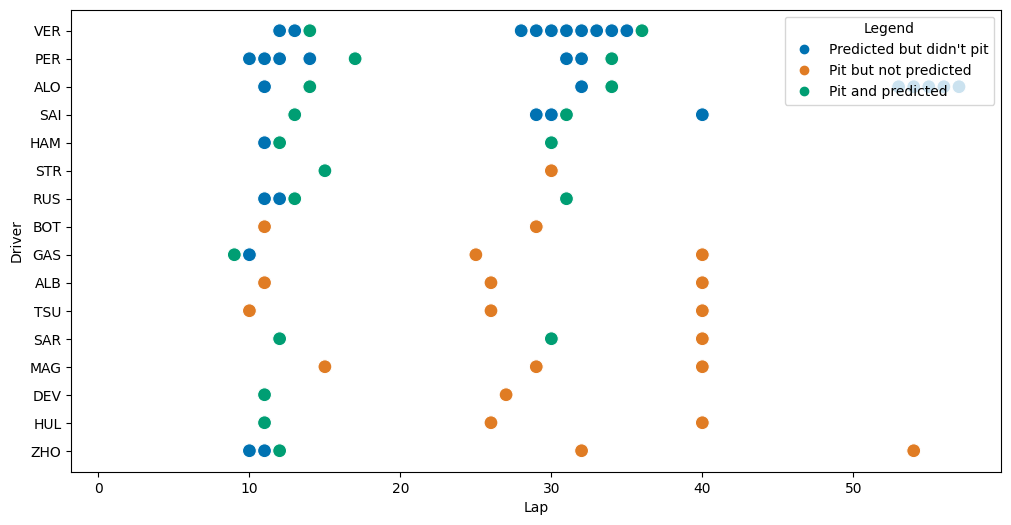

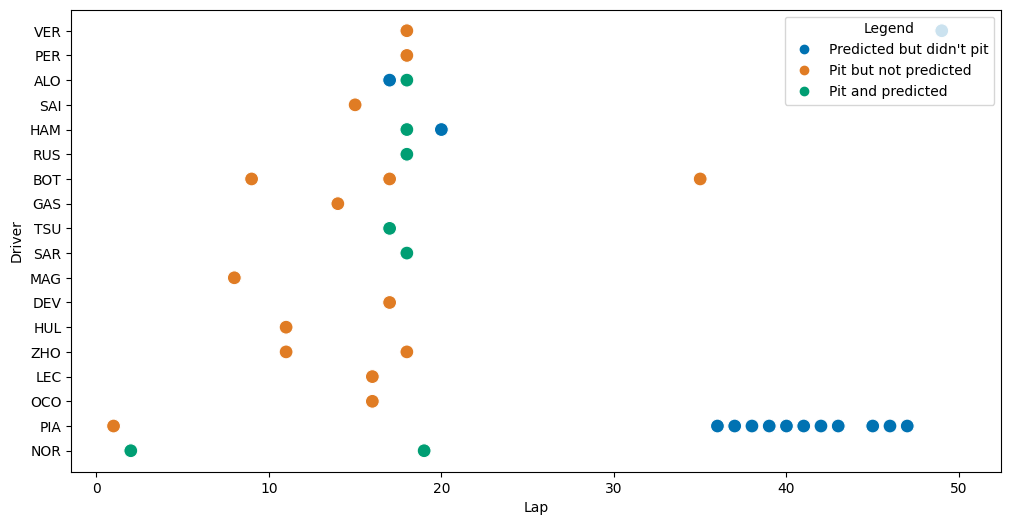

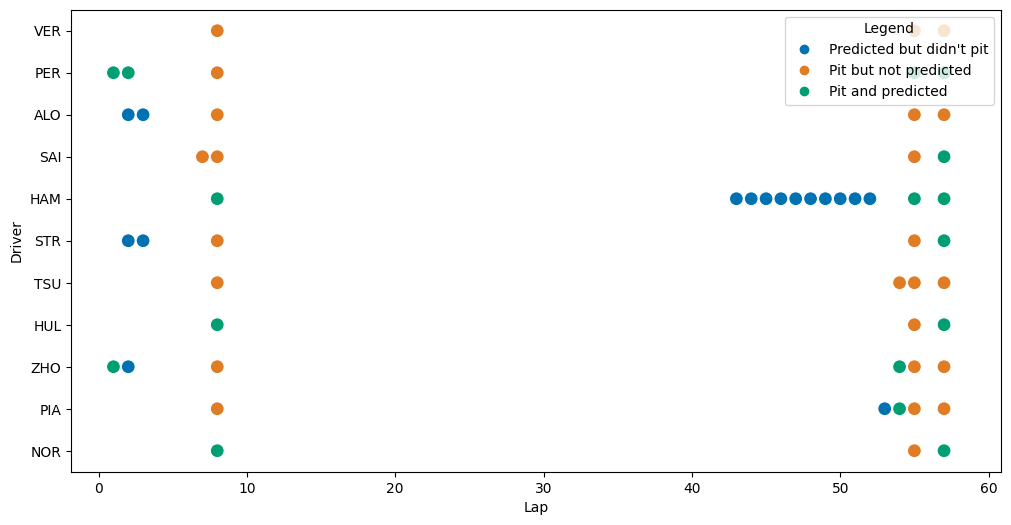

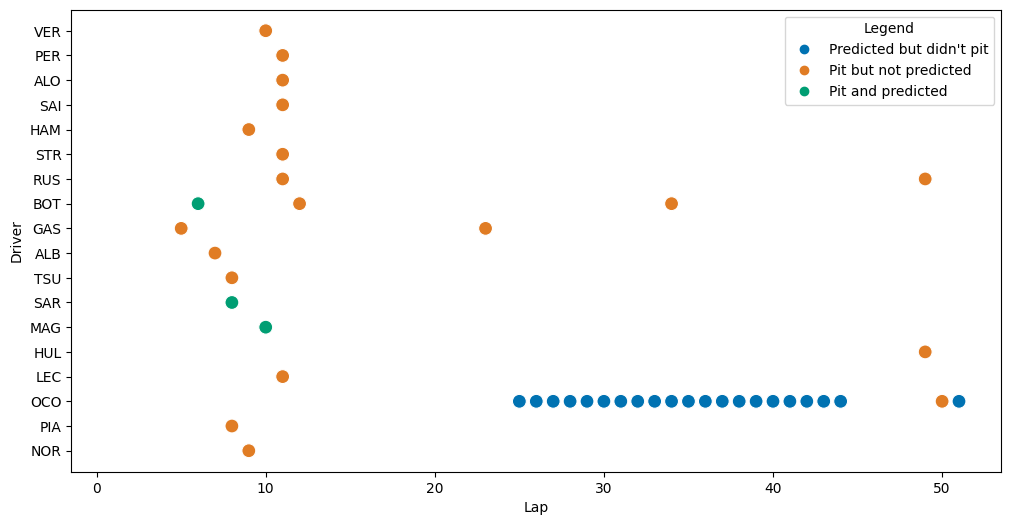

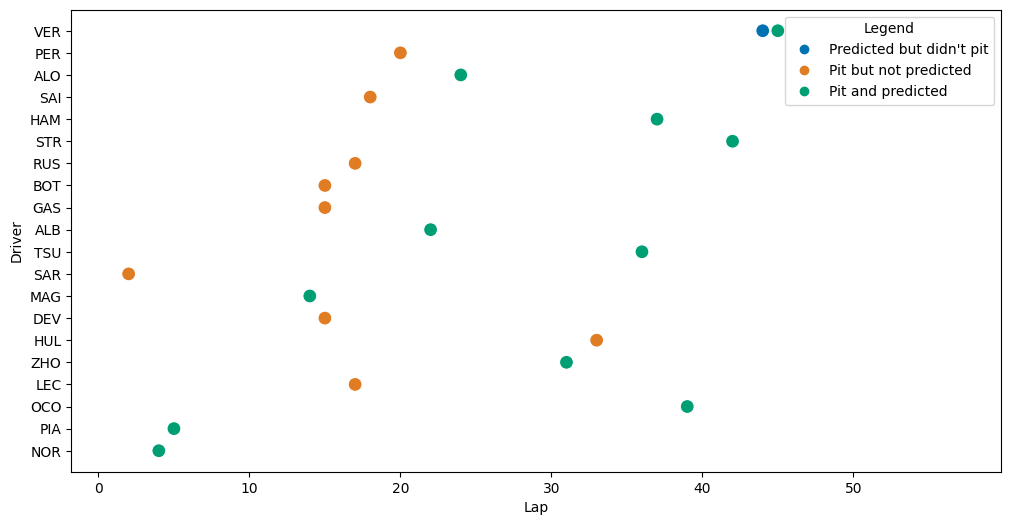

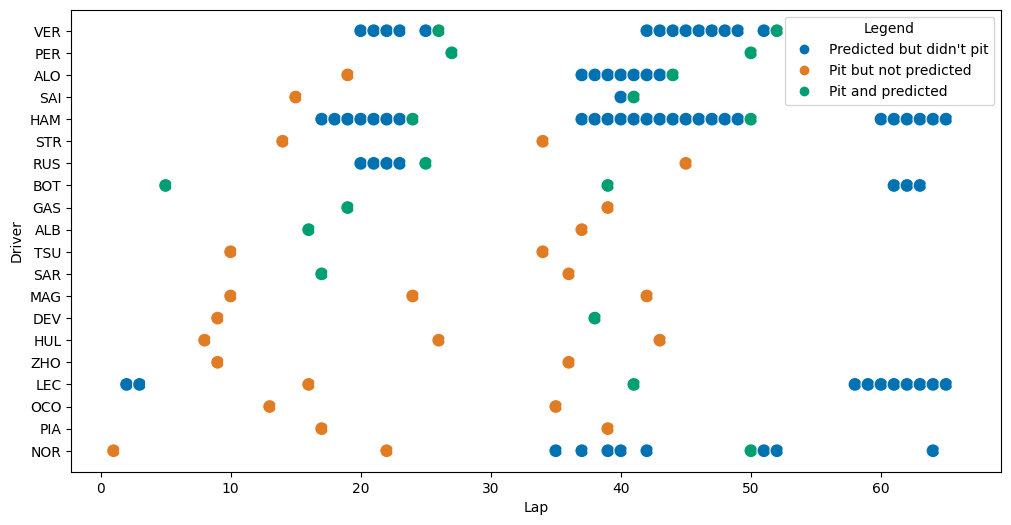

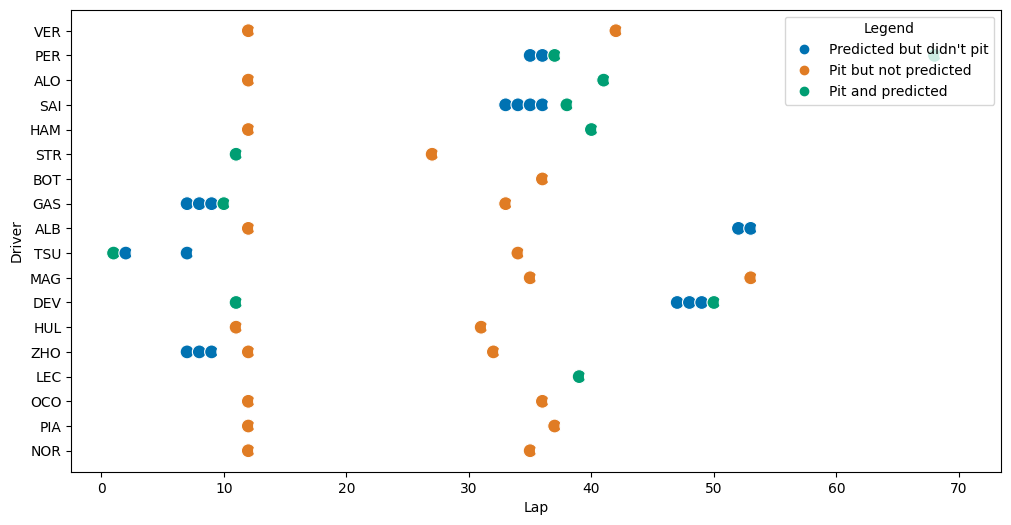

In [137]:
for receN in range(1,df_2023['RaceNumber'].unique().max()):
    df_list = []
    for driver in df_2023['Driver'].unique() :

        race_driver = df_2023[(df_2023['Driver'] == driver)  & (df_2023['RaceNumber'] == receN)]
        if(len(race_driver) == 0) : #its one of the deleted drivers
            continue
        
        to_predict = df_encoded_2023.loc[race_driver.index].reindex(columns=X_train_full.columns, fill_value=0)
        
        null_cols = to_predict.columns[to_predict.isnull().any()]

        predictions = SVM_res.predict(to_predict).astype(int)
        real = race_driver['HasPitLap'].values
        #real = race_driver['PitNextLap'].values


        laps = np.arange(1, len(real)+1)

        driver_df = pd.DataFrame({'Driver': [driver]*len(real),
                                'Real': real,
                                'Predict': predictions,
                                'Lap': laps})

        df_list.append(driver_df)
    if (len(df_list)==0):
        continue
    
    plot_df = pd.concat(df_list, ignore_index=True)

    # Create a colum for the color 
    # 0: No pit, not predicted 
    # 1: No pit, yes predicted 
    # 2: Yes pit, not predicted 
    # 3: Yes pit, yes predicted 
    plot_df['ColorCode'] = (plot_df['Real'] * 2 + plot_df['Predict']).astype(int)
    plot(receN, plot_df)

### Final result

In [167]:
def plot(name, plot_df):
    # Define color palette and labels
    palette = {0: 'white', 1: "#0072B2", 2: "#E07C24", 3: "#009E73"}
    labels = {1: 'Predicted but didn\'t pit', 2: 'Pit but not predicted', 3: 'Pit and predicted'}
    label_colors = {1:  "#0072B2", 2: "#E07C24", 3: "#009E73"}

    # Create scatter plot
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=plot_df, x='Lap', y='Driver', hue='ColorCode', palette=palette, s=100)

    legend_handles = [plt.Line2D([], [], marker='o', color=label_colors[i], linestyle='') for i in labels.keys()]
    legend = plt.legend(title='Legend', labels=labels.values(), loc='upper right', handles=legend_handles, frameon=True)

    # Set legend background color with alpha value for transparency
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(1)  # Adjust alpha value (0.0 to 1.0) for desired transparency level

    plt.savefig("img/2023/2023_race" + str(name), dpi=300, bbox_inches='tight')
    plt.show()



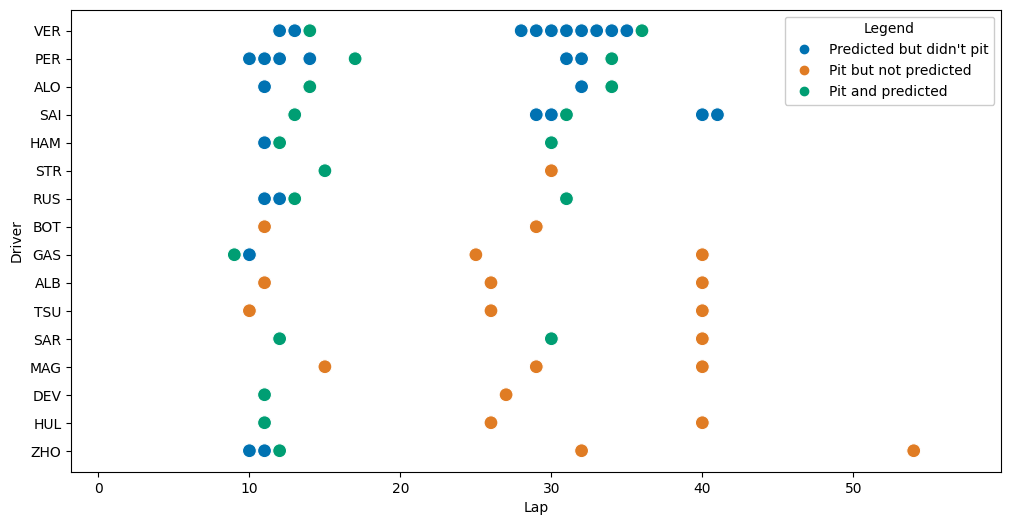

In [168]:
df_list = []
for driver in df_2023['Driver'].unique() :

    race_driver = df_2023[(df_2023['Driver'] == driver)  & (df_2023['RaceNumber'] == 1)]
    if(len(race_driver) == 0) : #its one of the deleted drivers
        continue
        
    to_predict = df_encoded_2023.loc[race_driver.index].reindex(columns=X_train_full.columns, fill_value=0)
        
    null_cols = to_predict.columns[to_predict.isnull().any()]

    predictions = SVM_res.predict(to_predict).astype(int)
    real = race_driver['HasPitLap'].values

    laps = np.arange(1, len(real)+1)

    driver_df = pd.DataFrame({'Driver': [driver]*len(real),
                                'Real': real,
                                'Predict': predictions,
                                'Lap': laps})

    df_list.append(driver_df)
    
plot_df = pd.concat(df_list, ignore_index=True)

    # Create a colum for the color 
    # 0: No pit, not predicted 
    # 1: No pit, yes predicted 
    # 2: Yes pit, not predicted 
    # 3: Yes pit, yes predicted 
plot_df['ColorCode'] = (plot_df['Real'] * 2 + plot_df['Predict']).astype(int)
plot(receN, plot_df)